<div align="center"> 
    <hr>
  <font size="6"><b>Dev | Clean-Clean Entity Resolution Notebook</b> </font>
   <hr>
</div>

In [72]:
!python --version

Python 3.10.9


In [160]:
import os
import sys
import pandas as pd
import networkx
from networkx import draw, Graph
%load_ext autoreload
%autoreload 2
%reload_ext autoreload
from pyjedai.utils import (
    text_cleaning_method,
    print_clusters,
    print_blocks,
    print_candidate_pairs
)
from pyjedai.evaluation import Evaluation, write
from pyjedai.datamodel import Data
d1 = pd.read_csv("./data/ccer/D2/abt.csv", sep='|', engine='python', na_filter=False).astype(str)
d2 = pd.read_csv("./data/ccer/D2/buy.csv", sep='|', engine='python', na_filter=False).astype(str)
gt = pd.read_csv("./data/ccer/D2/gt.csv", sep='|', engine='python')

data = Data(
    dataset_1=d1,
    attributes_1=['id','name','description'],
    id_column_name_1='id',
    dataset_2=d2,
    attributes_2=['id','name','description'],
    id_column_name_2='id',
    ground_truth=gt,
)

The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload


# Block Building

In [162]:
from pyjedai.block_building import (
    StandardBlocking,
    QGramsBlocking,
    ExtendedQGramsBlocking,
    SuffixArraysBlocking,
    ExtendedSuffixArraysBlocking,
)

In [163]:
qgb = QGramsBlocking(qgrams=6)
blocks = qgb.build_blocks(data, attributes_1=['name'], attributes_2=['name'])

Q-Grams Blocking:   0%|          | 0/2152 [00:00<?, ?it/s]

In [164]:
qgb.evaluate(blocks, with_classification_report=True)

***************************************************************************************************************************
                                         Μethod:  Q-Grams Blocking
***************************************************************************************************************************
Method name: Q-Grams Blocking
Parameters: 
	Q-Gramms: 6
Runtime: 0.0900 seconds
───────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────
Performance:
	Precision:      0.32% 
	Recall:        99.91%
	F1-score:       0.63%
───────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────
Classification report:
	True positives: 1075
	False positives: 337743
	True negatives: 820032
	False negatives: 1
	Total comparisons: 338818
───────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────


{'Precision %': 0.3172794833804579,
 'Recall %': 99.90706319702602,
 'F1 %': 0.6325501479873138,
 'True Positives': 1075,
 'False Positives': 337743,
 'True Negatives': 820032,
 'False Negatives': 1}

# Block Cleaning

In [165]:
from pyjedai.block_cleaning import BlockFiltering

In [166]:
bf = BlockFiltering(ratio=0.8)
filtered_blocks = bf.process(blocks, data, tqdm_disable=False)

Block Filtering:   0%|          | 0/3 [00:00<?, ?it/s]

# Comparison Cleaning


In [167]:
from pyjedai.block_cleaning import BlockPurging

In [168]:
cbbp = BlockPurging()
cleaned_blocks = cbbp.process(filtered_blocks, data, tqdm_disable=False)

Block Purging:   0%|          | 0/5048 [00:00<?, ?it/s]

In [169]:
cbbp.evaluate(cleaned_blocks, with_classification_report=True)

***************************************************************************************************************************
                                         Μethod:  Block Purging
***************************************************************************************************************************
Method name: Block Purging
Parameters: 
	Smoothing factor: 1.025
	Max Comparisons per Block: 3224.0
Runtime: 0.0256 seconds
───────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────
Performance:
	Precision:      0.89% 
	Recall:        99.26%
	F1-score:       1.77%
───────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────
Classification report:
	True positives: 1068
	False positives: 118793
	True negatives: 1038975
	False negatives: 8
	Total comparisons: 119861
───────────────────────────────────────────────────────────────────────────────────────────

{'Precision %': 0.8910321121966278,
 'Recall %': 99.25650557620817,
 'F1 %': 1.7662088525430595,
 'True Positives': 1068,
 'False Positives': 118793,
 'True Negatives': 1038975,
 'False Negatives': 8}

## Meta Blocking

In [82]:
from pyjedai.comparison_cleaning import (
    WeightedEdgePruning,
    WeightedNodePruning,
    CardinalityEdgePruning,
    CardinalityNodePruning,
    BLAST,
    ReciprocalCardinalityNodePruning,
    ReciprocalWeightedNodePruning,
    ComparisonPropagation
)

In [12]:
wep = CardinalityEdgePruning(weighting_scheme='X2')
candidate_pairs_blocks = wep.process(filtered_blocks, data)

Cardinality Edge Pruning:   0%|          | 0/1076 [00:00<?, ?it/s]

In [13]:
wep.evaluate(candidate_pairs_blocks, with_classification_report=True)

***************************************************************************************************************************
                                         Μethod:  Cardinality Edge Pruning
***************************************************************************************************************************
Method name: Cardinality Edge Pruning
Parameters: 
	Node centric: False
	Weighting scheme: X2
Runtime: 2.4874 seconds
───────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────
Performance:
	Precision:      9.79% 
	Recall:        92.47%
	F1-score:      17.70%
───────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────
Classification report:
	True positives: 995
	False positives: 9171
	True negatives: 1148524
	False negatives: 81
	Total comparisons: 10166
─────────────────────────────────────────────────────────────────────────────────────────

{'Precision %': 9.78752705095416,
 'Recall %': 92.4721189591078,
 'F1 %': 17.701476605586194,
 'True Positives': 995,
 'False Positives': 9171,
 'True Negatives': 1148524,
 'False Negatives': 81}

# Entity Matching

It compares pairs of entity profiles, associating every pair with a similarity in [0,1]. Its output comprises the similarity graph, i.e., an undirected, weighted graph where the nodes correspond to entities and the edges connect pairs of compared entities.

In [11]:
from pyjedai.matching import EntityMatching

In [13]:
EM = EntityMatching(
    metric='dice',
    similarity_threshold=0.4,
    attributes = ['description', 'name']
)

pairs_graph = EM.predict(candidate_pairs_blocks, data, tqdm_disable=True)

NameError: name 'EntityMatching' is not defined

In [16]:
EM.evaluate(pairs_graph)

***************************************************************************************************************************
                                         Μethod:  Entity Matching
***************************************************************************************************************************
Method name: Entity Matching
Parameters: 
	Tokenizer: white_space_tokenizer
	Metric: dice
	Similarity Threshold: 0.4
Runtime: 1.2030 seconds
───────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────
Performance:
	Precision:     69.50% 
	Recall:        20.54%
	F1-score:      31.71%
───────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────


{'Precision %': 69.49685534591194,
 'Recall %': 20.53903345724907,
 'F1 %': 31.70731707317073,
 'True Positives': 221,
 'False Positives': 97,
 'True Negatives': 1156824,
 'False Negatives': 855}

# Progressive Entity Matching

Applies Entity Matching to a subset of candidate pairs based on prioritization scheme.

In [195]:
from pyjedai.prioritization import (
    GlobalTopPM,
    LocalTopPM,
    EmbeddingsNNBPM,
    GlobalPSNM,
    LocalPSNM,
    RandomPM,
    PESM
)

In [189]:
LTPM = LocalTopPM(
    budget = 20000,
    w_scheme = 'X2',
    metric='dice',
    similarity_threshold=0.1,
    attributes = ['description', 'name']
)

ltpm_pairs_graph = LTPM.predict(cleaned_blocks, data, tqdm_disable=True)

In [190]:
GTPM = GlobalTopPM(
    budget = 20000,
    w_scheme = 'X2',
    metric='dice',
    similarity_threshold=0.1,
    attributes = ['description', 'name']
)

gtpm_pairs_graph = GTPM.predict(cleaned_blocks, data, tqdm_disable=True)

In [191]:
GPSNM = GlobalPSNM(
    budget = 20000,
    pwScheme = 'ID',
    metric='dice',
    similarity_threshold=0.1,
    attributes = ['description', 'name']
)

gpsnm_pairs_graph = GPSNM.predict(cleaned_blocks, data, tqdm_disable=True)

In [192]:
LPSNM = LocalPSNM(
    budget = 20000,
    pwScheme = 'ID',
    metric='dice',
    similarity_threshold=0.1,
    attributes = ['description', 'name']
)

lpsnm_pairs_graph = LPSNM.predict(cleaned_blocks, data, tqdm_disable=True)

In [20]:
ENNBPM = EmbeddingsNNBPM(
    budget = 20000,
    vectorizer = 'roberta',
    similarity_search = 'faiss',
    emission= 'avg',
    metric = 'dice',
    tokenizer = 'white_space_tokenizer',
    similarity_threshold = 0.1
)
ennbpm_pairs_graph = ENNBPM.predict(candidate_pairs_blocks, data, wep, tqdm_disable=True)

Device selected:  cpu
Vector size:  (1058, 768)
Vectors-1 entering FAISS (1058, 768)
Train FAISS with  (1058, 768)
Indices returned:  (1058, 10)


In [199]:
rpm = RandomPM(
    budget = 20000,
    metric='dice',
    similarity_threshold=0.1,
    attributes = ['description', 'name']
)

rpm_pairs_graph = rpm.predict(cleaned_blocks, data, tqdm_disable=True)

In [204]:
pesm = PESM(
    budget = 20000,
    w_scheme = 'X2',
    metric='dice',
    similarity_threshold=0.1,
    attributes = ['description', 'name']
)

pesm_pairs_graph = pesm.predict(cleaned_blocks, data, tqdm_disable=True)

In [210]:
print(list(edge[1:] for edge in pesm_pairs_graph))

[(0, 1129), (1, 1227), (2, 2075), (3, 1268), (4, 1226), (5, 1264), (6, 1286), (7, 1234), (8, 1340), (9, 1252), (10, 1133), (11, 1252), (12, 1707), (13, 1134), (14, 1132), (15, 1132), (16, 1558), (17, 1906), (18, 1284), (19, 1155), (20, 1155), (21, 1269), (22, 1138), (23, 1555), (24, 1118), (25, 1164), (26, 1274), (27, 1123), (28, 1124), (29, 1119), (30, 1117), (31, 1707), (32, 1126), (33, 1271), (34, 1156), (35, 1272), (36, 1284), (37, 1461), (38, 1140), (39, 2045), (40, 1870), (41, 1872), (42, 1872), (43, 1251), (44, 1267), (45, 1932), (46, 1285), (47, 1155), (48, 1139), (49, 1177), (50, 1131), (51, 1426), (52, 1332), (53, 1192), (54, 1140), (55, 1177), (56, 1182), (57, 1181), (58, 1141), (59, 1092), (60, 1147), (61, 1153), (62, 1135), (63, 1200), (64, 1148), (65, 1150), (66, 1388), (67, 1298), (68, 1295), (69, 1368), (70, 2013), (71, 1183), (72, 1152), (73, 1931), (74, 1931), (75, 1300), (76, 1187), (77, 1183), (78, 1156), (79, 1222), (80, 1151), (81, 1330), (82, 1144), (83, 1273), (

In [186]:
methods_prediction_data = []

# rpm_pairs_graph.edges = sorted(rpm_pairs_graph.edges(data=True), key=lambda x: x[2]['weight'], reverse=True)
# gtpm_pairs_graph.edges = sorted(gtpm_pairs_graph.edges(data=True), key=lambda x: x[2]['weight'], reverse=True)

# ltpm_pairs_graph.edges = [edge[:2] for edge in ltpm_pairs_graph.edges]
# gtpm_pairs_graph.edges = [edge[:2] for edge in gtpm_pairs_graph.edges]


methods_prediction_data.append(("Random", list([edge[:2] for edge in rpm_pairs_graph.edges])))
methods_prediction_data.append(("Entity Esch", list(edge[1:] for edge in pesm_pairs_graph)))
methods_prediction_data.append(("Global Sorted Neighborhood", gpsnm_pairs_graph))
# methods_prediction_data.append(("Local Sorted Neighborhood", lpsnm_pairs_graph))
# methods_prediction_data.append(("Embedding BNN", list(ennbpm_pairs_graph)))

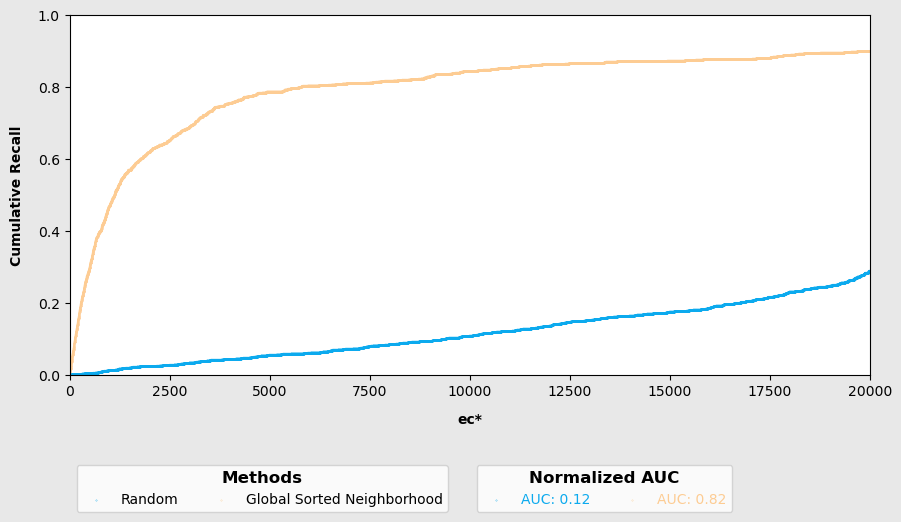

CPU times: user 265 ms, sys: 4.01 ms, total: 269 ms
Wall time: 269 ms


In [187]:
%%time
GPSNM.evaluate_auc_roc(methods_prediction_data = methods_prediction_data, proportional = False)

# Entity Clustering

It takes as input the similarity graph produced by Entity Matching and partitions it into a set of equivalence clusters, with every cluster corresponding to a distinct real-world object.

In [ ]:
from pyjedai.clustering import ConnectedComponentsClustering, UniqueMappingClustering

In [ ]:
ccc = ConnectedComponentsClustering()
clusters = ccc.process(pairs_graph, data)

In [ ]:
ccc.evaluate(clusters, with_classification_report=True)

In [ ]:
from pyjedai.clustering import ConnectedComponentsClustering, UniqueMappingClustering
umc = UniqueMappingClustering()
clusters = umc.process(pairs_graph, data)

In [ ]:
umc.evaluate(clusters, with_classification_report=True)